In [1]:
import numpy as np
from dctkit.mesh import util
from dctkit.math.opt import optctrl
from dctkit.physics.elasticity import LinearElasticity
import dctkit as dt
import pygmsh
import jax.numpy as jnp
from functools import partial
import dctkit.dec.cochain as C
from matplotlib.pyplot import triplot

In [2]:
dt.config()

In [3]:
lc = 0.2
L = 1.
with pygmsh.geo.Geometry() as geom:
    p = geom.add_polygon([[0., 0.], [L, 0.], [L, L], [0., L]], mesh_size=lc)
    # create a default physical group for the boundary lines
    geom.add_physical(p.lines, label="boundary")
    geom.add_physical(p.lines[0], label="down")
    geom.add_physical(p.lines[2], label="up")
    geom.add_physical(p.lines[1], label="right")
    geom.add_physical(p.lines[3], label="left")
    mesh = geom.generate_mesh()

S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()
S.get_flat_DPD_weights()
S.get_flat_DPP_weights()

ref_node_coords = S.node_coords

In [4]:
bnd_edges_idx = S.bnd_faces_indices
down_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "down")
up_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "up")
down_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "down")
up_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "up")
left_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "left")
right_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "right")
left_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "left")
right_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "right")

bottom_left_corner = left_bnd_nodes_idx.pop(0)

mu_ = 1.
lambda_ = 10.
true_strain_xx = 0.2
true_strain_yy = -(lambda_/(2*mu_+lambda_))*true_strain_xx
sigma_ = 2*mu_*(true_strain_xx) + lambda_*(true_strain_xx + true_strain_yy)
true_curr_node_coords = S.node_coords.copy()
true_curr_node_coords[:, 0] *= 1 + true_strain_xx
true_curr_node_coords[:, 1] *= 1 + true_strain_yy
left_bnd_pos_components = [0]
right_bnd_pos_components = [0]

In [5]:
left_bnd_nodes_pos = ref_node_coords[left_bnd_nodes_idx,
                                     :][:, left_bnd_pos_components]
right_bnd_nodes_pos = true_curr_node_coords[right_bnd_nodes_idx,
                                            :][:, right_bnd_pos_components]
bottom_left_corner_pos = ref_node_coords[bottom_left_corner, :]

# NOTE: without flatten it does not work properly when concatenating multiple bcs;
# fix this so that flatten is not needed (not intuitive)
# boundary_values = {"0": (left_bnd_nodes_idx + right_bnd_nodes_idx,
#                         np.vstack((left_bnd_nodes_pos,
#                                    right_bnd_nodes_pos)).flatten()),
#                   ":": (bottom_left_corner, bottom_left_corner_pos)}
boundary_values = {"0": (left_bnd_nodes_idx, left_bnd_nodes_pos),
                   ":": (bottom_left_corner, bottom_left_corner_pos)}

idx_free_edges = list(set(bnd_edges_idx) -
                      set(right_bnd_edges_idx) - set(left_bnd_edges_idx))
left_right_edges_idx = left_bnd_edges_idx+right_bnd_edges_idx
bnd_tractions_free_values = np.zeros((len(idx_free_edges), 2), dtype=dt.float_dtype)
bnd_tractions_left_right_values = np.zeros(
    (len(left_right_edges_idx)), dtype=dt.float_dtype)

boundary_tractions = {':': (idx_free_edges, bnd_tractions_free_values),
                      '1': (left_right_edges_idx, bnd_tractions_left_right_values)}

ela = LinearElasticity(S=S, mu_=mu_, lambda_=lambda_)
gamma = 100000.

In [24]:
num_faces = S.S[2].shape[0]
embedded_dim = S.space_dim
f = np.zeros((num_faces, (embedded_dim-1)))
obj = ela.obj_linear_elasticity_energy

num_edges = S.S[1].shape[0]

primal_vol_right = S.primal_volumes[1][right_bnd_edges_idx]

idx = S.S[1][right_bnd_edges_idx,:]
print(S.node_coords[idx,:])

bnd_tractions_right = sigma_ * \
    np.ones(len(right_bnd_edges_idx), dtype=dt.float_dtype)
bnd_tractions_right *= primal_vol_right
#bnd_tractions_right[-1] *= -1

ext_forces_coeffs = np.zeros((num_edges, 3), dtype=dt.float_dtype)
ext_forces_coeffs[right_bnd_edges_idx, 0] = bnd_tractions_right

obj_args = {'f': f, 'gamma': gamma,
            'boundary_values': boundary_values, 'ext_forces': ext_forces_coeffs}
x0 = S.node_coords.flatten()

[[[1.  0.  0. ]
  [1.  0.2 0. ]]

 [[1.  0.2 0. ]
  [1.  0.4 0. ]]

 [[1.  0.4 0. ]
  [1.  0.6 0. ]]

 [[1.  0.6 0. ]
  [1.  0.8 0. ]]

 [[1.  1.  0. ]
  [1.  0.8 0. ]]]


In [13]:
prb = optctrl.OptimizationProblem(dim=len(x0),
                                  state_dim=len(x0),
                                  objfun=obj)

prb.set_obj_args(obj_args)
sol = prb.solve(x0=x0, ftol_abs=1e-12, ftol_rel=1e-12, maxeval=100000)
print(prb.last_opt_result)
curr_node_coords = sol.reshape(S.node_coords.shape)

Traced<ShapedArray(float64[109,3])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float64[109,3])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float64[109,3])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float64[109,3]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fa384165e40>, in_tracers=(Traced<ShapedArray(float64[109,3]):JaxprTrace(level=2/0)>, Traced<ShapedArray(float64[109,3]):JaxprTrace(level=2/0)>), out_tracer_refs=[<weakref at 0x7fa344569c60; to 'JaxprTracer' at 0x7fa344569c10>], out_avals=[ShapedArray(float64[109,3])], primitive=pjit, params={'jaxpr': { lambda ; a:f64[109,3] b:f64[109,3]. let c:f64[109,3] = mul b a in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invars': (False, False), 'name': 'fn', 'keep_unused': False, 'inline': True}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0

In [14]:
true_node_coch = C.CochainP0(S, curr_node_coords)
f_coch = C.CochainP2(S, f)
#res = ela.force_balance_residual_primal(true_node_coch, f_coch, boundary_tractions)
forces = ela.force_balance_residual_primal(true_node_coch, f_coch, boundary_tractions)
print(forces.coeffs[left_bnd_edges_idx,:])

[[-1.46666604e-01  1.85823157e-08]
 [-1.46666632e-01 -4.07708370e-08]
 [-1.46666732e-01 -4.79301582e-08]
 [-1.46666851e-01 -6.80451075e-08]
 [ 1.46666827e-01 -1.02641417e-07]]


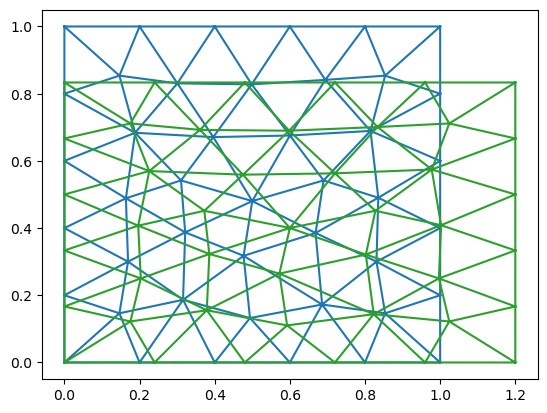

In [15]:
triplot(ref_node_coords[:,0], ref_node_coords[:,1], triangles=S.S[2])
triplot(curr_node_coords[:,0], curr_node_coords[:,1], triangles=S.S[2])

In [17]:
print(ela.obj_linear_elasticity_energy(curr_node_coords, f, gamma, boundary_values, ext_forces_coeffs))


[[ 0.          0.          0.        ]
 [ 0.         -0.          0.        ]
 [ 0.         -0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.02933337 -0.          0.        ]
 [ 0.         -0.          0.        ]
 [ 0.02933335 -0.          0.        ]
 [ 0.         -0.          0.        ]
 [ 0.         -0.          0.        ]
 [ 0.         -0.          0.        ]
 [ 0.         -0.          0.        ]
 [ 0.         -0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.         -0.          0.        ]
 [ 0.         -0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.         -0.          0.        ]
 [ 0.         -0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.         -0.          0.        ]
 [ 0.         -0.          0.        ]
 [ 0.         -0.          0.        ]
 [ 0.         -0.          0.        ]
 [ 0.02933336 -0.          0.        ]
 [ 0.         -0.          0.        ]
 [ 0.         -0.        

In [22]:
print(true_curr_node_coords)
print(curr_node_coords)
print(np.allclose(true_curr_node_coords, curr_node_coords, atol=1e-5))

[[0.         0.         0.        ]
 [1.2        0.         0.        ]
 [1.2        0.83333333 0.        ]
 [0.         0.83333333 0.        ]
 [0.24       0.         0.        ]
 [0.48       0.         0.        ]
 [0.72       0.         0.        ]
 [0.96       0.         0.        ]
 [1.2        0.16666667 0.        ]
 [1.2        0.33333333 0.        ]
 [1.2        0.5        0.        ]
 [1.2        0.66666667 0.        ]
 [0.96       0.83333333 0.        ]
 [0.72       0.83333333 0.        ]
 [0.48       0.83333333 0.        ]
 [0.24       0.83333333 0.        ]
 [0.         0.66666667 0.        ]
 [0.         0.5        0.        ]
 [0.         0.33333333 0.        ]
 [0.         0.16666667 0.        ]
 [0.19644793 0.4072209  0.        ]
 [1.00241958 0.40858307 0.        ]
 [0.59270214 0.11031337 0.        ]
 [0.59803848 0.68978222 0.        ]
 [0.36089783 0.69225243 0.        ]
 [0.47539185 0.55894537 0.        ]
 [0.72024191 0.56293241 0.        ]
 [0.6        0.40032063 0.  